In [ ]:
def posterior_distribution(model_checkpoint: str,
                  processed_dir: str = "processed_data",
                  n_rows: int = 200,
                  n_samples: int = 600,
                  random_state: int = 42,
                  select_halo_ids: list = None,
                  select_snapshots: list = None):
    """
    Plot Figure 14: posterior vs prior vs MAP vs truth for either
    `n_rows` random test galaxies or for a specified list of (HaloID, Snapshot) pairs.
    Each subplot is elongated (wider & shorter) to give more horizontal room.
    """
    import os
    import numpy as np
    import pandas as pd
    import torch
    import joblib
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import train_test_split
    from model import cINN

    # 1) Load scaled data + metadata + scalers
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    df_meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_full  = dfX.values               # scaled observables
    Y_full  = dfY.values               # scaled targets
    obs_sc  = joblib.load(os.path.join(processed_dir, "obs_scaler.pkl"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape

    # 2) Re-split to recover exactly the same test-set indices
    idx              = np.arange(N)
    idx_tmp, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    val_frac         = 0.1 / 0.9
    idx_train, idx_val = train_test_split(idx_tmp, test_size=val_frac, random_state=random_state)

    X_test    = X_full[idx_test]
    Y_test    = Y_full[idx_test]
    meta_test = df_meta.iloc[idx_test].reset_index(drop=True)
    halo_ids     = meta_test["HaloID"].values
    snapshot_ids = meta_test["Snapshot"].values

    # 3) Build “prior” KDEs on each target in physical units
    Yp = tar_sc.inverse_transform(Y_test)
    priors = []
    for d in range(D_tar):
        data = Yp[:, d][:, None]
        kde  = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(data)
        grid = np.linspace(data.min(), data.max(), 200)[:, None]
        dens = np.exp(kde.score_samples(grid))
        dens /= dens.max()
        priors.append((grid.ravel(), dens))

    # 4) Load your trained cINN
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device).eval()
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)

    # 5) Select test galaxies
    if select_halo_ids is not None and select_snapshots is not None:
        if len(select_halo_ids) != len(select_snapshots):
            raise ValueError("select_halo_ids and select_snapshots must have equal length")
        chosen = []
        for hid, snap in zip(select_halo_ids, select_snapshots):
            matches = meta_test[
                (meta_test["HaloID"] == hid) &
                (meta_test["Snapshot"] == snap)
            ].index.tolist()
            if not matches:
                raise ValueError(f"No test entry for HaloID={hid}, Snapshot={snap}")
            chosen.append(matches[0])
        n_rows = len(chosen)
    else:
        rng    = np.random.RandomState(random_state)
        chosen = rng.choice(len(X_test), size=n_rows, replace=False)
    # ensure chosen is a list
    chosen = list(chosen)

    # 6) Sample posteriors, compute MAPs & gather truths
    post_phys = np.zeros((n_rows, n_samples, D_tar))
    maps_phys = np.zeros((n_rows, D_tar))
    true_phys = np.zeros((n_rows, D_tar))

    for i_row, idx0 in enumerate(chosen):
        x0 = torch.tensor(X_test[idx0:idx0+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv_out = model.inverse(Z, x0.repeat(n_samples, 1))
            Ys = inv_out[0] if isinstance(inv_out, tuple) else inv_out
        Ys = Ys.cpu().numpy()
        post_phys[i_row] = tar_sc.inverse_transform(Ys)

        # MAP via KDE
        for d in range(D_tar):
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(samp)
            g2   = np.linspace(samp.min(), samp.max(), 200)[:, None]
            ld2  = kde2.score_samples(g2)
            maps_phys[i_row, d] = g2[np.argmax(np.exp(ld2)), 0]

        true_phys[i_row] = tar_sc.inverse_transform(Y_test[idx0:idx0+1])[0]

    # 7) Plot the grid (elongated subplots)
    target_labels = [
        'Time of Collision (Gyr)',
        'Velocity of Collision (km/s)',
        r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
        r'Subcluster mass ($10^{14} \, M_{\odot}$)',
        'Mass Ratio',
        'Pericenter distance (kpc)',
    ]

    # make each plot wider and shorter
    fig, axes = plt.subplots(
        n_rows, D_tar,
        figsize=(3 * D_tar, 1.25 * n_rows),
        sharex="col", squeeze=False
    )

    for i_row, gal in enumerate(chosen):
        axes[i_row, 0].text(
            -0.12, 0.5,
            f"{snapshot_ids[gal]}\n{halo_ids[gal]}",
            transform=axes[i_row, 0].transAxes,
            va="center", ha="right", fontsize=8
        )
        for d in range(D_tar):
            ax = axes[i_row, d]

            # PRIOR: grey fill + black dashed line
            g_prior, pd_prior = priors[d]
            ax.fill_between(g_prior, pd_prior, color="lightgrey", alpha=0.6)
            ax.plot      (g_prior, pd_prior, "k--", lw=1)

            # POSTERIOR: smooth KDE
            samp = post_phys[i_row, :, d][:, None]
            kde2 = KernelDensity(kernel="gaussian", bandwidth=0.3).fit(samp)
            g_post = np.linspace(samp.min(), samp.max(), 200)[:, None]
            pd_post = np.exp(kde2.score_samples(g_post))
            pd_post /= pd_post.max()
            ax.plot(g_post.ravel(), pd_post, color="C0", lw=2)

            # MAP & truth
            ax.axvline(maps_phys[i_row, d], color="gold", lw=1.5)
            ax.axvline(true_phys[i_row, d], color="red",  lw=1.5)

            # lock x‐axis to prior range (unchanged)
            ax.set_xlim(g_prior.min(), g_prior.max())

            # ——— show numeric ticks on the bottom row only ———
            if i_row == n_rows - 1:
                ticks = np.linspace(g_prior.min(), g_prior.max(), 5)
                ax.set_xticks(ticks)
                ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=6, rotation=45)
            else:
                ax.set_xticks([])

            # ——— label each column on the first row ———
            if i_row == 0:
                ax.set_title(target_labels[d], fontsize=10)

            ax.set_yticks([])

    plt.tight_layout()

    # save as pdf and png
    #fig.savefig("1.posterior_distrubution.pdf", bbox_inches="tight")
    fig.savefig("1.posterior_distrubution.png", bbox_inches="tight")
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_29731/29990023.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loade

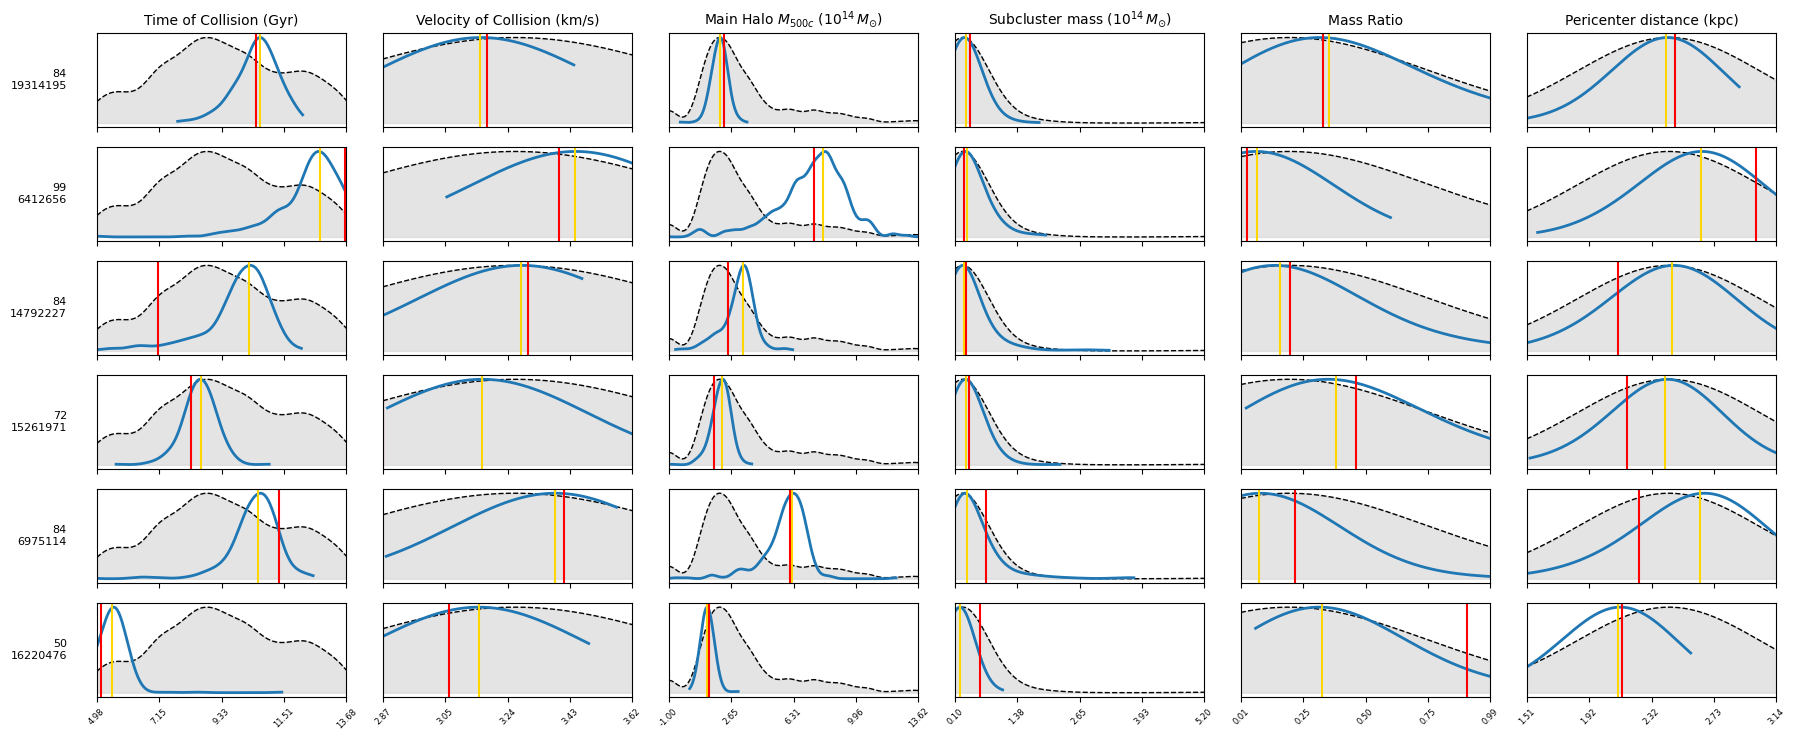

In [52]:
# plot by specifying exact galaxies:
#halo_ids    = [12274768, 14397702, 16831981, 14034933, 10250314, 14781744, 7895542
                #,16617127, 1791552, 12274768, 18938111, 11419483, 7308175, 14768508, 7308175]
#snapshots   = [99, 99, 67, 84, 84, 72, 67
                #, 59, 84, 99, 84, 91, 50, 67, 50]
posterior_distribution("best_cluster_cinn.pt", processed_dir="processed_data",
              #select_halo_ids=halo_ids,
              #select_snapshots=snapshots,
              n_samples=300,
              n_rows=6,
              random_state=6)
